In [1]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
from IPython.display import Image

In [3]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import re
import random

from bert4keras.backend import keras, K
from bert4keras.tokenizers import Tokenizer
from bert4keras.models import build_transformer_model
from bert4keras.optimizers import Adam
from bert4keras.snippets import sequence_padding, DataGenerator
from keras.layers import Lambda, Dense

C:\Users\jin\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\jin\anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Users\jin\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)
Using TensorFlow backend.


## Load Dataset

In [4]:
df = pd.read_csv('-3240472320249870393offsite-test-material//offsite-tagging-training-set.csv')
df.shape

(2737, 3)

In [5]:
df.head(3)

,id,tag,text
0,544490,拜登,美國總統大選民調再次在關鍵州份失誤，本來形勢一片大好的民主黨候選人拜登竟而未能創造如外界預期...
1,603578,新盤市況,由南豐集團及港鐵（0066）合作的日出康城LP6，將於下周六（3日）首度推售266個停車位，...
2,596897,新盤市況,由會德豐地產及信置（083）牽頭發展的西南九龍維港滙 I ，本月初已先後推出兩張價單，涉及共...


#### Check if any null value in dataset

In [6]:
df.isna().sum()

id      0
tag     0
text    0
dtype: int64

In [7]:
df['tag'] = df['tag'].astype(str)
df['text'] = df['text'].astype(str)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2737 entries, 0 to 2736
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2737 non-null   int64 
 1   tag     2737 non-null   object
 2   text    2737 non-null   object
dtypes: int64(1), object(2)
memory usage: 64.3+ KB


#### Check unique value of 'tag' column, do label encoding and create a id-tag mapping dict

In [9]:
df['tag'].value_counts()

拜登      1576
新盤市況     586
NBA      575
Name: tag, dtype: int64

In [10]:
le = preprocessing.LabelEncoder()
le.fit(df['tag'])
df['tag_id'] = le.transform(df['tag'])

In [11]:
label_dict = dict(zip(range(len(le.classes_)), le.classes_, ))

#### Check the length of 'text' column and it is apprently too long for a classification task.
#### Because the task is about <span style="color:red">text classification</span> and the genre of text is news which will hit the main point at the beginning (mostly), so I decide to split the article by period, and use <span style="color:red">first sentence</span> to feed the model. 
#### After the observation of column '1st_len'(length of 1st sentence), I decide to use <span style="color:red">128</span> as max_len of our model, and only <span style="color:red">6%</span> of article's first sentence's length are larger than this number. (Because BERT takes two special charcter during encoding process, so the actual length will be 128-2)

In [12]:
df['len'] = df['text'].apply(lambda x: len(x))

In [13]:
df['len'].describe()

count     2737.000000
mean       955.103398
std       1008.255435
min        115.000000
25%        444.000000
50%        677.000000
75%       1197.000000
max      29194.000000
Name: len, dtype: float64

In [14]:
df['1st_sent'] = df['text'].apply(lambda x: re.split(r'。', x)[0])

In [15]:
df['1st_len'] = df['1st_sent'].apply(lambda x: len(x))

In [16]:
df['1st_len'].describe()

count    2737.000000
mean       70.261600
std        35.868917
min         8.000000
25%        45.000000
50%        66.000000
75%        90.000000
max       533.000000
Name: 1st_len, dtype: float64

In [17]:
len(df[df['1st_len']>128-2])/len(df)

0.06101571063207892

## Prepare Dataset to feed the model, take 70% as training set and 30% as validation set

In [18]:
x = df['text']
y = df['tag_id']

all_data = []
for i in range(len(x)):
    all_data.append([x[i],y[i]])

In [19]:
random.seed(22)
random.shuffle(all_data)

train_data = all_data[:len(all_data) *7 //10 ]
valid_data = all_data[len(all_data) *7 //10 :]

## Transform Data

In [20]:
class data_generator(DataGenerator):    
    
    def __init__(self, data, batch_size, tokenizer, maxlen):
        super().__init__(data, batch_size)
        self.maxlen = maxlen
        self.tokenizer = tokenizer   
    
    def __iter__(self, random=False):
        batch_token_ids, batch_segment_ids, batch_labels = [], [], []
        for is_end, (text, label) in self.sample(random):
            token_ids, segment_ids = self.tokenizer.encode(text, maxlen=self.maxlen)
            batch_token_ids.append(token_ids)
            batch_segment_ids.append(segment_ids)
            batch_labels.append([label])
            if len(batch_token_ids) == self.batch_size or is_end:
                batch_token_ids = sequence_padding(batch_token_ids)
                batch_segment_ids = sequence_padding(batch_segment_ids)
                batch_labels = sequence_padding(batch_labels)
                yield [batch_token_ids, batch_segment_ids], batch_labels
                batch_token_ids, batch_segment_ids, batch_labels = [], [], []

## Build Bert Model

In [21]:
def build_model(config_path, checkpoint_path, dict_path, learning_rate=2e-5, dropout_rate=0.1):
    
    bert = build_transformer_model(
        config_path=config_path,
        checkpoint_path=checkpoint_path,
        dropout_rate= dropout_rate,
        return_keras_model=False,
    )            
    output = Lambda(lambda x: x[:, 0])(bert.model.output)
    
    output = Dense(
        units=len(set(y)),
        activation='softmax',
        kernel_initializer=bert.initializer
    )(output)

    model = keras.models.Model(bert.model.input, output)
    
    model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate),
    metrics=['accuracy']
    )
    
    return model

In [22]:
class Evaluator(keras.callbacks.Callback):
    
    @staticmethod
    def evaluate(data):
        total, right = 0., 0.
        for x_true, y_true in data:
            y_pred = model.predict(x_true).argmax(axis=1)
            y_true = y_true[:, 0]
            total += len(y_true)
            right += (y_true == y_pred).sum()
        return right / total
    
    def __init__(self, target_patience=3):
        self.best_val_acc = 0.
        self.patience = 0
        self.target_patience = target_patience        

    def on_epoch_end(self, epoch, logs=None):
        val_acc = self.evaluate(valid_generator)
        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc            
            model.save_weights('best_model.weights')
            self.patience = 0
        else:
            self.patience += 1
            if self.patience >= self.target_patience:
                self.model.stop_training = True
                model.load_weights('best_model.weights')
        print(
            u'val_acc: %.5f, best_val_acc: %.5f\n' %
            (val_acc, self.best_val_acc)
        )

## Parameter for BERT

In [23]:
maxlen = 128
batch_size = 16
learning_rate = 5e-5
dropout_rate = 0.1

In [24]:
bert_version = 'chinese_rbt3_L-3_H-768_A-12/'
config_path = bert_version + 'bert_config_rbt3.json'
checkpoint_path = bert_version + 'bert_model.ckpt'
dict_path =bert_version + 'vocab.txt'

In [25]:
tokenizer = Tokenizer(dict_path)

In [26]:
train_generator = data_generator(train_data, batch_size, tokenizer, maxlen)
valid_generator = data_generator(valid_data, batch_size, tokenizer, maxlen)

## Training

In [27]:
print('*'*50)
model = build_model(config_path, checkpoint_path, dict_path, learning_rate, dropout_rate)
evaluator = Evaluator(3)
model.fit(train_generator.forfit(),
          steps_per_epoch=len(train_generator),
          epochs=50,
          callbacks=[evaluator]
         )
print('BEST ACCURACY: ', evaluator.best_val_acc)
print('\t')
print('\t')

**************************************************


C:\Users\jin\anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/50
120/120 [==============================] - 12s 102ms/step - loss: 0.1307 - accuracy: 0.9514
val_acc: 0.98662, best_val_acc: 0.98662

Epoch 2/50
120/120 [==============================] - 11s 89ms/step - loss: 0.0109 - accuracy: 0.99531s
val_acc: 0.99027, best_val_acc: 0.99027

Epoch 3/50
120/120 [==============================] - 11s 89ms/step - loss: 0.0018 - accuracy: 0.9995
val_acc: 0.99027, best_val_acc: 0.99027

Epoch 4/50
120/120 [==============================] - 10s 86ms/step - loss: 0.0059 - accuracy: 0.9984
val_acc: 0.99148, best_val_acc: 0.99148

Epoch 5/50
120/120 [==============================] - 11s 92ms/step - loss: 0.0037 - accuracy: 0.9990
val_acc: 0.98905, best_val_acc: 0.99148

Epoch 6/50
120/120 [==============================] - 11s 88ms/step - loss: 6.6513e-04 - accuracy: 1.0000
val_acc: 0.99392, best_val_acc: 0.99392

Epoch 7/50
120/120 [==============================] - 10s 87ms/step - loss: 2.3181e-04 - accuracy: 1.0000
val_acc: 0.99392, best_val_ac

## Predict text & Return Tag with highest probabilities

In [28]:
def predict(x):
    token_ids, segment_ids = tokenizer.encode(x, maxlen=maxlen)
    result = model.predict([[token_ids],[segment_ids]])    
    tag_id  = result.argmax(axis=1)[0]
    return label_dict[tag_id]

In [29]:
df_predict = pd.read_csv('-3240472320249870393offsite-test-material//offsite-tagging-test-set.csv')

In [30]:
df_predict['tag'] = df_predict['text'].apply(lambda x: predict(x))

In [31]:
df_predict.head()

,id,text,tag
0,585198,自拜登入主白宮，各方都在等待中猜測：中美兩國最高領導人究竟何時通話？通話談什麼？談話又將啟動...,拜登
1,523051,湖人與火箭在西岸四強爭奪決賽資格，雖然火箭一開始在系列賽中先拔頭籌，不過湖人試陣後找到適合的...,NBA
2,496396,NBA將於美國時間7月30日於奧蘭多迪士尼園區復賽，22支球隊亦於今天進駐園區，相繼接受病毒...,NBA
3,543351,美國大選2020倒數兩天，《華盛頓郵報》報道，不少歐洲外交人員4年前對美國總統特朗普逆轉勝感...,拜登
4,486685,美國前副總統拜登（Joe Biden）將代表民主黨出戰大選，力爭阻止現任總統特朗普（Dona...,拜登


In [32]:
# df_predict.iloc[155].text

In [33]:
df_predict[['id','tag']].to_csv('predict.csv')

# Questions:

### 1) How well does your model perform?

My model get <span style="color:red">1.0000</span> at training set and <span style="color:red">0.9939</span> at validation set. (Metrics: <span style="color:red">Accuracy</span>)

### 2) How did you choose the parameters of the final model?

<li>max_len: As mentioned above, it's based on stat result from 1st sentence of the article, and 94% of data are under this range.
<li>batch_size: Based on the power of GPU, normally the larger the better for BERT model.
<li>learning_rate and dropout_rate:  The recommended value from BERT paper
<li>Early_Stopping Patience: I choose 3 for early stoopping on accuracy of validation set, in case of overfitting problem.

### 3) On a high level, please explain your final model’s structure, and how it predicts tags from the article text

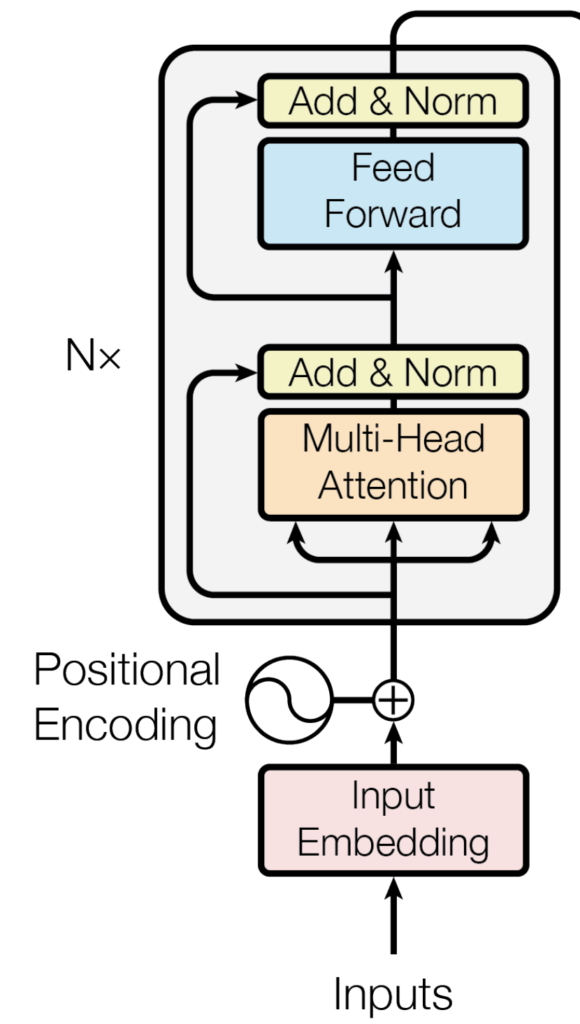

In [34]:
Image(filename = "bert_structure.png", width=200, height=200)

I choose <strong>BERT (Chinese with 3layer)</strong> to handle this task, because it can provide great accuracy on classification tasks with much lower computing power costing. The model I use in this task can be seperated into two parts: <strong>BERT</strong> and <strong>Fine-tuning</strong>.

For <strong>BERT</strong>, as we can see from above cell, it contains an <strong>Input_Embedding</strong> layer and multiple (Nx) <strong>Blocks</strong>, and N equals to 3 in our tasks.

For Input_Embedding, it will transform word ids (mapping from Dictionary) into vectors in a certain shape.

For every Block, BERT will run a mechanism named <strong>self attention</strong>, which will occupied attention weighing to every words. Normally, more meaningful the word to the sentence, the larger weighting it will  get. After multiple rounds calculations in the blocks, BERT will return a <strong>sentence embedding</strong> for Fine-tuning part.

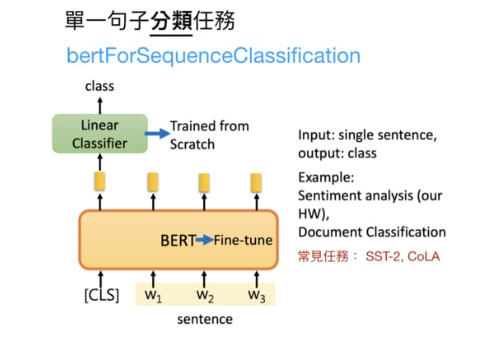

In [35]:
Image(filename = "fine_tune.png", width=500, height=500)

For <strong>Fine-tuning</strong> part, we will let <strong>sentence embedding</strong> go through a classifier layer (softmax in our task) to get an array of probabilities for each tags. And we will take the tag with highest probabilities as the predicted tag.